# Sentiment Analysis on World Street Journal Data

In [28]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.stattools import grangercausalitytests
from textblob import TextBlob

In [6]:
wsjFile = 'wsj_dataset.csv'
initial_df = pd.read_csv(wsjFile)

initial_df.head(10)

,date,title,softTitle,text,url,keywords,tags/0
0,2023-11-10,Marketing and Media News,Marketing and Media News,Bed and mattress brand Sleep Number said it re...,https://www.wsj.com/news/cmo-today?mod=nav_top...,"CMO, chief marketing officer, cmo news, chief ...",NaN
1,2023-07-10T21:22:00.000Z,What It's Like to Be Wrongfully Detained Overseas,What It's Like to Be Wrongfully Detained Overseas,What's News brings you the headlines and busin...,https://www.wsj.com/podcasts/whats-news/what-i...,"wall street journal columnists, analysis colum...",NaN
2,2023-11-10,Dow Opens Higher Ahead of Veteran's Day; Gloom...,Stock Market Today: Dow Opens Higher Ahead of ...,U. S. stocks are looking to end the week on a ...,https://www.wsj.com/livecoverage/stock-market-...,NaN,NaN
3,2023-11-08,"Israel Plans Humanitarian Pauses, U.S. Says, a...",Israel-Hamas War Live Updates: Israel Plans Hu...,Secretary of State Antony Blinken said that wh...,https://www.wsj.com/livecoverage/israel-hamas-...,NaN,NaN
4,2023-11-10T10:30:00.000Z,Why Are We So Obsessed with Sam Bankman-Fried’...,Why Are We So Obsessed with Sam Bankman-Fried’...,During the trial for disgraced crypto-wunderki...,https://www.wsj.com/us-news/law/why-are-we-so-...,"wsjreview,Financial Investment Services,Securi...",NaN
5,2023-07-10T21:22:00.000Z,What It's Like to Be Wrongfully Detained Overseas,What It's Like to Be Wrongfully Detained Overseas,What's News brings you the headlines and busin...,https://www.wsj.com/podcasts/whats-news/what-i...,"wall street journal columnists, analysis colum...",NaN
6,2023-11-10T16:00:00.000Z,"Two Minnesotans Retired in Cornwall, England. ...","Two Minnesotans Retired in Cornwall, England. ...",We didn’t move to Britain to undermine British...,https://www.wsj.com/lifestyle/travel/retiring-...,"journal reports,retirement,encore,encorereport...",NaN
7,2023-11-09T22:54:00.000Z,Brie Larson Leads a Not-So-Supergroup,‘The Marvels’ Review: Brie Larson Leads a Not-...,‘The Marvels” arrives amid a rumbling storm of...,https://www.wsj.com/arts-culture/film/the-marv...,"arts in review,Audiovisual Production,Media/En...",NaN
8,2023-11-08T15:52:00.000Z,Best Travel Credit Cards for 2024,Best Travel Credit Cards for 2024,Inflation is pushing up prices nearly everywhe...,https://www.wsj.com/buyside/personal-finance/b...,NaN,NaN
9,2023-11-10,Marketing and Media News,Marketing and Media News,Bed and mattress brand Sleep Number said it re...,https://www.wsj.com/news/cmo-today?mod=hp_mino...,"CMO, chief marketing officer, cmo news, chief ...",NaN


## Data Cleaning and Pre-processing

### Delete unwanted columns

In [7]:
#Remove tags, keywords and url column
df = initial_df.drop(columns=['tags/0', 'keywords', 'url'])
df.head(10)

,date,title,softTitle,text
0,2023-11-10,Marketing and Media News,Marketing and Media News,Bed and mattress brand Sleep Number said it re...
1,2023-07-10T21:22:00.000Z,What It's Like to Be Wrongfully Detained Overseas,What It's Like to Be Wrongfully Detained Overseas,What's News brings you the headlines and busin...
2,2023-11-10,Dow Opens Higher Ahead of Veteran's Day; Gloom...,Stock Market Today: Dow Opens Higher Ahead of ...,U. S. stocks are looking to end the week on a ...
3,2023-11-08,"Israel Plans Humanitarian Pauses, U.S. Says, a...",Israel-Hamas War Live Updates: Israel Plans Hu...,Secretary of State Antony Blinken said that wh...
4,2023-11-10T10:30:00.000Z,Why Are We So Obsessed with Sam Bankman-Fried’...,Why Are We So Obsessed with Sam Bankman-Fried’...,During the trial for disgraced crypto-wunderki...
5,2023-07-10T21:22:00.000Z,What It's Like to Be Wrongfully Detained Overseas,What It's Like to Be Wrongfully Detained Overseas,What's News brings you the headlines and busin...
6,2023-11-10T16:00:00.000Z,"Two Minnesotans Retired in Cornwall, England. ...","Two Minnesotans Retired in Cornwall, England. ...",We didn’t move to Britain to undermine British...
7,2023-11-09T22:54:00.000Z,Brie Larson Leads a Not-So-Supergroup,‘The Marvels’ Review: Brie Larson Leads a Not-...,‘The Marvels” arrives amid a rumbling storm of...
8,2023-11-08T15:52:00.000Z,Best Travel Credit Cards for 2024,Best Travel Credit Cards for 2024,Inflation is pushing up prices nearly everywhe...
9,2023-11-10,Marketing and Media News,Marketing and Media News,Bed and mattress brand Sleep Number said it re...


In [8]:
#Handle missing values if any
missing_values = df.isnull().sum()
missing_values

date         0
title        0
softTitle    0
text         0
dtype: int64

In [9]:
# Generalise date time column
date_values = df['date'].values
date_values_updated = []

for value in date_values:
    if 'T' in value:
        # Converting to a datetime object
        datetime_obj = datetime.fromisoformat(value.rstrip("Z"))
        # Extracting just the date part
        value = datetime_obj.date().isoformat()
        
    date_values_updated.append(value)

# Change the format of date to datetime for easy processing
df['date'] = date_values_updated
df.head()

,date,title,softTitle,text
0,2023-11-10,Marketing and Media News,Marketing and Media News,Bed and mattress brand Sleep Number said it re...
1,2023-07-10,What It's Like to Be Wrongfully Detained Overseas,What It's Like to Be Wrongfully Detained Overseas,What's News brings you the headlines and busin...
2,2023-11-10,Dow Opens Higher Ahead of Veteran's Day; Gloom...,Stock Market Today: Dow Opens Higher Ahead of ...,U. S. stocks are looking to end the week on a ...
3,2023-11-08,"Israel Plans Humanitarian Pauses, U.S. Says, a...",Israel-Hamas War Live Updates: Israel Plans Hu...,Secretary of State Antony Blinken said that wh...
4,2023-11-10,Why Are We So Obsessed with Sam Bankman-Fried’...,Why Are We So Obsessed with Sam Bankman-Fried’...,During the trial for disgraced crypto-wunderki...


In [11]:
# Remove special characters
def remove_special_characters(text):
    text = text.replace('\n', ' ')
    return re.sub(r'[^a-zA-Z\s]', '', text, re.I| re.A)

df['text'] = df['text'].apply(remove_special_characters)

df['text'].head()

0    Bed and mattress brand Sleep Number said it re...
1    Whats News brings you the headlines and busine...
2    U S stocks are looking to end the week on a hi...
3    Secretary of State Antony Blinken said that wh...
4    During the trial for disgraced cryptowunderkin...
Name: text, dtype: object

### Split the data into different dataframes based on different companies

In [12]:
# Companies mapping with their keywords
finalKeywordsMapping = {
    'JPM': ['JPM', 'Jamie Dimon', 'Jeremy Barnum', 'Lori Beer', 'Daniel E. Pinto', 'JPMorgan', 'JPMorgan Chase', 'JPMorgan Chase & Co', 'JPMorgan & Chase', 'Chase', 'Chase Sapphire Preferred', 'Chase Sapphire Reserve', 'Chase Freedom Flex', 'Chase Freedom Unlimited', 'Chase Slate Edge', 'Chase Ink Business Cards', 'First Republic Bank', 'Global Shares PLC', 'Frank Financial Aid', 'Volkswagen Payments SA', 'Nutmeg Saving and Investment Ltd', 'JPMorgan Coin', 'Onyx', 'Ownera'],
    'BAC': ['BAC', 'Brian Moynihan', 'Alastair Borthwick', 'Amadeo Giannini', 'Hugh McColl', 'Bank of America', 'Banc of America', 'Bank of America Private Bank', 'Balboa', 'BankAmericard', 'Alaska Airlines Visa', 'Alaska Airlines', 'Axia', 'AxiaMed', 'BACSIL'],
    'WFC': ['WFC', 'Charles W. Scharf', 'Scott Powell', 'Michael P. Santomassimo', 'William Fargo', 'Wells Fargo', 'Wells Fargo Autograph', 'Wells Fargo Active Cash', 'Wells Fargo Reflect', 'Bilt Mastercard', 'Choice Privileges', 'GTCR', 'Wells Fargo Digital Cash', 'Elliptic'],
    'C': ['C ', 'Jane Fraser', 'Michael Corbat', 'Citi', 'Citigroup', 'Citibank', 'Citi Double Cash', 'Citi Premier', 'Citi Custom Cash', 'Anywhere Visa', 'AAdvantage', 'Consumer Bank'],
    'GS': ['GS', 'David Solomon', 'Denis Coleman', 'Marco Argenti', 'John E. Waldron', 'Atte Lahtiranta', 'Goldman Sachs', 'Goldman', 'Sachs', 'Apple Card', 'Marcus', 'GreenSky', 'NN Investments', 'Next Capital', 'Ethereum Blockchain', 'Fnality', 'Metaverse'],
    'MS': ['MS', 'James Gorman', 'Sharon Yeshaya', 'Ted Pick', 'Andy Saperstein', 'Morgan Stanley', 'Stanley', 'Blue Cash', 'E trade', 'Eaton Vance', 'Figment', 'NYDIG', 'Defi'],
    'AXP': ['AXP', 'Stephen Squeri', 'John Butterfield', 'William Fargo', 'Henry Wells', 'Amex', 'American Express', 'Gold Card', 'Platinum Card', 'American Express Green Card', 'Delta SkyMiles', 'Hilton Honors', 'Marriott Bonvoy', 'Kabbage', 'Nipendo', 'Web3', 'Abra'],
    'V': ['V ', 'Ryan McInerney', 'Dee Hock', 'AI Kelly', 'Visa', 'Classic', 'Signature', 'Visa Platinum', 'Infinite', 'Currency cloud', 'Tink', 'Pismo', 'Visa B2B Connect', 'Wirex'],
    'MA': ['MA', 'Michael Miebach', 'Sachin Mehra', 'Raja Rajamannar', 'Ed McLaughlin', 'Mastercard', 'Standard Mastercard', 'World Elite', 'Gold Mastercard', 'Elite Mastercard', 'Finicity', 'Ekata', 'Aiia', 'CipherTrace', 'Arcus Financial Intelligence', 'Baffin Bay Networds', 'Dynamic Yield', 'Mastercard Crypto Credential', 'Aptos Labs', 'Ava Labs', 'Polygon', 'Solana'],
    'SCHW': ['SCHW', 'Walter W Bettinger II', 'Charles R. Schwab', 'Charles Schwab', 'Schwab', 'Schwab Investor', 'TD Ameritrade', 'Family Wealth Alliance', 'Wasmer', 'Schroeder', 'Schwab Crypto Thematic ETF', 'STCE']
}

finalKeywordsMapping

{'JPM': ['JPM',
  'Jamie Dimon',
  'Jeremy Barnum',
  'Lori Beer',
  'Daniel E. Pinto',
  'JPMorgan',
  'JPMorgan Chase',
  'JPMorgan Chase & Co',
  'JPMorgan & Chase',
  'Chase',
  'Chase Sapphire Preferred',
  'Chase Sapphire Reserve',
  'Chase Freedom Flex',
  'Chase Freedom Unlimited',
  'Chase Slate Edge',
  'Chase Ink Business Cards',
  'First Republic Bank',
  'Global Shares PLC',
  'Frank Financial Aid',
  'Volkswagen Payments SA',
  'Nutmeg Saving and Investment Ltd',
  'JPMorgan Coin',
  'Onyx',
  'Ownera'],
 'BAC': ['BAC',
  'Brian Moynihan',
  'Alastair Borthwick',
  'Amadeo Giannini',
  'Hugh McColl',
  'Bank of America',
  'Banc of America',
  'Bank of America Private Bank',
  'Balboa',
  'BankAmericard',
  'Alaska Airlines Visa',
  'Alaska Airlines',
  'Axia',
  'AxiaMed',
  'BACSIL'],
 'WFC': ['WFC',
  'Charles W. Scharf',
  'Scott Powell',
  'Michael P. Santomassimo',
  'William Fargo',
  'Wells Fargo',
  'Wells Fargo Autograph',
  'Wells Fargo Active Cash',
  'Wells F

In [13]:
# Filter out the dataframes
filteredDfs = {}

for key, keywords in finalKeywordsMapping.items():
    mask = df['text'].str.contains('|'.join(keywords), case=True, na=False)
    # Filtering the DataFrame based on the mask
    filtered_df = df[mask]

    # Removing duplicate rows based on the 'title' column
    filtered_df_unique = filtered_df.drop_duplicates(subset=['title'])

    # Storing the filtered and deduplicated DataFrame
    filteredDfs[key] = filtered_df_unique


filteredDfs

{'JPM':            date                                              title  \
 8    2023-11-08                  Best Travel Credit Cards for 2024   
 29   2022-06-20             If You Want One Travel Card…This Is It   
 30   2023-08-16  How to Score Big Credit Card Rewards—Without P...   
 31   2022-07-03                 The Best Travel Card for Beginners   
 33   2022-06-27     The Ultimate Travel Card for Serious Travelers   
 ..          ...                                                ...   
 818  2023-03-24                  The Best Mortgage Lenders of 2023   
 819  2023-02-22  Your Credit Score Affects Your Mortgage Rate—H...   
 865  2022-12-23  12 Best Gym Bags to Carry All Your Workout Ess...   
 880  2023-04-23                 How to Budget as a College Student   
 948  2023-08-09  Everything You Need to Know About Shopping wit...   
 
                                              softTitle  \
 8                    Best Travel Credit Cards for 2024   
 29              If Y

In [14]:
# Print the newsArticles for each company
sum = 0
for key, item in filteredDfs.items():
    print("Company: ", key)
    print("News Articles: ", len(item))
    print()
    sum += len(item)
print(sum)

Company:  JPM
News Articles:  62

Company:  BAC
News Articles:  27

Company:  WFC
News Articles:  34

Company:  C
News Articles:  199

Company:  GS
News Articles:  22

Company:  MS
News Articles:  23

Company:  AXP
News Articles:  45

Company:  V
News Articles:  177

Company:  MA
News Articles:  32

Company:  SCHW
News Articles:  20

641


### Perform VADER Sentiment Analysis and Generate results

In [15]:
# Company standard for seperating the data into sentiments
def sentiment_value(compound):
    if compound > 0.05:
        return "Positive"
    elif compound < -0.5:
        return "Negative"
    elif compound >= -0.05 and compound < 0.05:
        return "Neutral"

In [16]:
analyzer = SentimentIntensityAnalyzer()

for key, item in filteredDfs.items():
    scoreV = item['text'].apply(lambda text: analyzer.polarity_scores(text))
    item['negativeV'] = scoreV.apply(lambda txt: txt['neg'])
    item['neutralV'] = scoreV.apply(lambda txt: txt['neu'])
    item['positiveV'] = scoreV.apply(lambda txt: txt['pos'])
    item['compoundV'] = scoreV.apply(lambda txt: txt['compound'])
    item['vaderSentiment'] = item['compoundV'].apply(lambda val: sentiment_value(val))

/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/935367690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['negativeV'] = scoreV.apply(lambda txt: txt['neg'])
/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/935367690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['neutralV'] = scoreV.apply(lambda txt: txt['neu'])
/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/935367690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [17]:
# Sort the result based on the date column in descending order
for key, item in filteredDfs.items():
    item = item.sort_values(by='date', ascending=False)
    print(item.head())

           date                                            title  \
76   2023-11-10    52 Early Black Friday Deals to Shop Right Now   
752  2023-11-10  Dow Closes Lower After Regional Bank Downgrades   
8    2023-11-08                Best Travel Credit Cards for 2024   
39   2023-11-08               Best Credit Cards for Black Friday   
82   2023-11-08                       The Best Bond ETFs of 2024   

                                             softTitle  \
76       52 Early Black Friday Deals to Shop Right Now   
752  Stock Market News, Aug. 8, 2023: Dow Closes Lo...   
8                    Best Travel Credit Cards for 2024   
39                  Best Credit Cards for Black Friday   
82                          The Best Bond ETFs of 2024   

                                                  text  negativeV  neutralV  \
76   Black Friday is still a few weeks away though ...      0.012     0.813   
752  U S stock indexes closed lower and government ...      0.086     0.840   
8    

### Sentiment Analysis using TextBlob

In [18]:
def getAnalysisInTermsOfSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [19]:
for key, data in filteredDfs.items():
    textBlobScore = data['text'].apply(lambda txt: TextBlob(txt))
    data['textBlobSentiment'] = textBlobScore.apply(lambda txt: getAnalysisInTermsOfSentiment(txt.sentiment.polarity))
    data['compoundT'] = textBlobScore.apply(lambda txt: txt.sentiment.polarity)
    data['subjectivityT'] = textBlobScore.apply(lambda txt: txt.sentiment.subjectivity)

/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/104238000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['textBlobSentiment'] = textBlobScore.apply(lambda txt: getAnalysisInTermsOfSentiment(txt.sentiment.polarity))
/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/104238000.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['compoundT'] = textBlobScore.apply(lambda txt: txt.sentiment.polarity)
/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_58027/10

In [20]:
filteredDfs['JPM'].head()

,date,title,softTitle,text,negativeV,neutralV,positiveV,compoundV,vaderSentiment,textBlobSentiment,compoundT,subjectivityT
8,2023-11-08,Best Travel Credit Cards for 2024,Best Travel Credit Cards for 2024,Inflation is pushing up prices nearly everywhe...,0.010,0.767,0.222,1.0000,Positive,Positive,0.200576,0.418600
29,2022-06-20,If You Want One Travel Card…This Is It,If You Want One Travel Card…This Is It,Capital One Venture Rewards Credit Card offers...,0.012,0.781,0.207,0.9996,Positive,Positive,0.210681,0.476468
30,2023-08-16,How to Score Big Credit Card Rewards—Without P...,How to Score Big Credit Card Rewards—Without P...,Credit card rewardswhen you do them rightcan f...,0.023,0.839,0.138,0.9991,Positive,Positive,0.177558,0.407909
31,2022-07-03,The Best Travel Card for Beginners,The Best Travel Card for Beginners,The Chase Sapphire Preferred Card is a solid p...,0.009,0.765,0.226,0.9996,Positive,Positive,0.190091,0.466640
33,2022-06-27,The Ultimate Travel Card for Serious Travelers,The Ultimate Travel Card for Serious Travelers,The Capital One Venture X Rewards Credit Card ...,0.021,0.808,0.171,0.9995,Positive,Positive,0.195115,0.478845


### Correlation between Stock Price Data and Sentiment Data

In [21]:
def adjustDateColumn(stockdf):
    # Generalise date time column
    date_values = stockdf['date'].values
    date_values_updated = []

    for value in date_values:
        if 'T' in value:
            # Converting to a datetime object
            datetime_obj = datetime.fromisoformat(value.rstrip("Z"))
            # Extracting just the date part
            value = datetime_obj.date().isoformat()
        
        date_values_updated.append(value)

    # Change the format of date to datetime for easy processing
    stockdf['date'] = date_values_updated
    return stockdf    

#### Create Dataframes for each company

In [43]:
stockDfs = {}
for key, value in finalKeywordsMapping.items():
    companyName = key

    stockFile = 'stockData/' + companyName + '_stockData.csv'
    stockDf = pd.read_csv(stockFile)
    stockDf.rename( columns={'Unnamed: 0':'date'}, inplace=True )
    stockDf = adjustDateColumn(stockDf)
    stockDf.drop(columns=['Daily Return'], inplace=True)

    stockDfs[companyName] = stockDf

#### Plot Graph between Sentiment Score and Stock Price

In [44]:
def plotGraph(mergedDf, algorithmColumn):
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Score', color=color)
    ax1.plot(mergedDf['date'], algorithmColumn, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Stock Price (Close)', color=color)
    ax2.plot(mergedDf['date'], mergedDf['Close'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title('Sentiment Analysis vs Stock Price Over Time')
    fig.tight_layout()

    plt.show()

In [49]:
def analysisPerAlgorithm(mergedDf, algorithmColumn, columnName):
    # Calculating the correlation
    correlation = algorithmColumn.corr(mergedDf['Close'])
    print("Correlation value: ", correlation)
    
    # Plot the Graph
    plotGraph(mergedDf, algorithmColumn)
    # Granger Causality Test
    gc_test_results = grangercausalitytests(mergedDf[['Close', columnName]], maxlag=5, verbose=True)

    # Extracting the p-values from the test results
    p_values = [round(gc_test_results[i+1][0]['ssr_chi2test'][1], 4) for i in range(5)]
    return p_values

### TextBlob Algorithm Results

Company:  JPM
Text Blob Algorithm Results:- 
Correlation value:  -0.014508929853943201


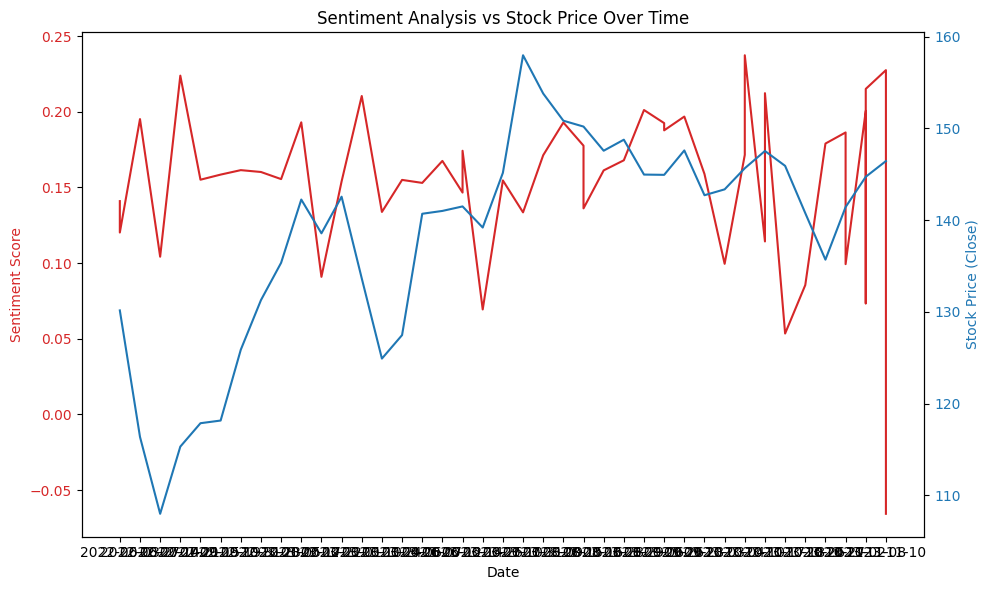

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1576  , p=0.6932  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=0.1679  , p=0.6820  , df=1
likelihood ratio test: chi2=0.1676  , p=0.6823  , df=1
parameter F test:         F=0.1576  , p=0.6932  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1519  , p=0.8595  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=0.3391  , p=0.8440  , df=2
likelihood ratio test: chi2=0.3379  , p=0.8445  , df=2
parameter F test:         F=0.1519  , p=0.8595  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5259  , p=0.6670  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=1.8537  , p=0.6033  , df=3
likelihood ratio test: chi2=1.8181  , p=0.6110  , df=3
parameter F test:         F=0.5259  , p=0.6670  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2642  , p=0.8990  , df_d

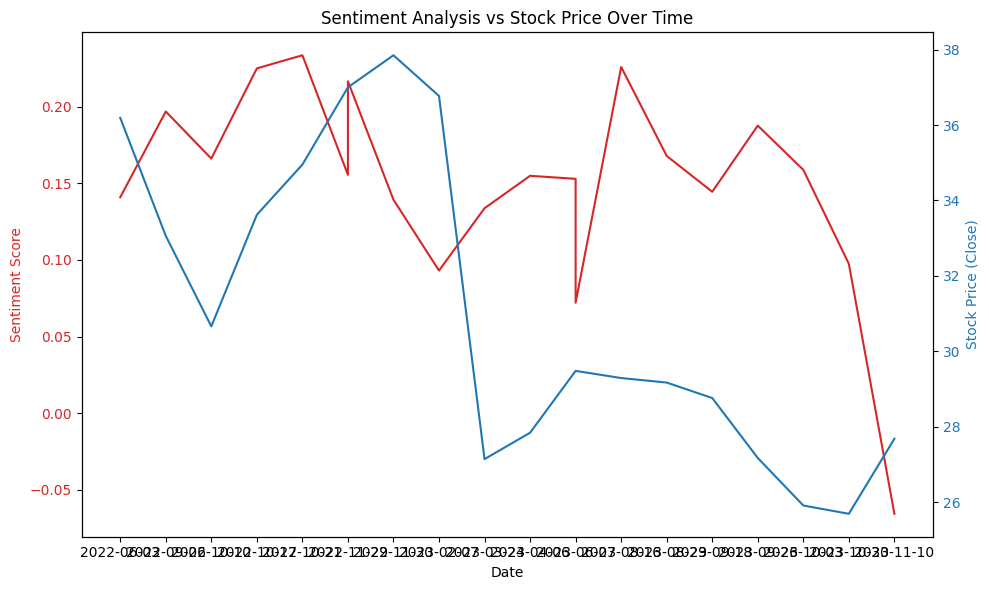

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4974  , p=0.0490  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=5.2911  , p=0.0214  , df=1
likelihood ratio test: chi2=4.6944  , p=0.0303  , df=1
parameter F test:         F=4.4974  , p=0.0490  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7909  , p=0.0955  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=7.5754  , p=0.0226  , df=2
likelihood ratio test: chi2=6.3754  , p=0.0413  , df=2
parameter F test:         F=2.7909  , p=0.0955  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7646  , p=0.2119  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=8.6626  , p=0.0341  , df=3
likelihood ratio test: chi2=7.0720  , p=0.0696  , df=3
parameter F test:         F=1.7646  , p=0.2119  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8279  , p=0.5432  , df_d

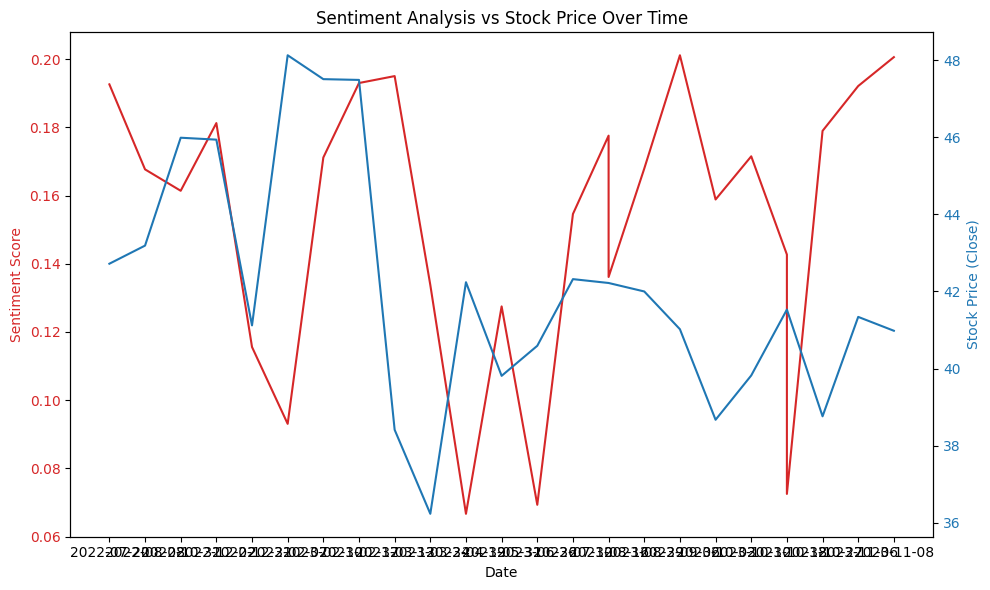

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0699  , p=0.3127  , df_denom=21, df_num=1
ssr based chi2 test:   chi2=1.2227  , p=0.2688  , df=1
likelihood ratio test: chi2=1.1926  , p=0.2748  , df=1
parameter F test:         F=1.0699  , p=0.3127  , df_denom=21, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4882  , p=0.6216  , df_denom=18, df_num=2
ssr based chi2 test:   chi2=1.2477  , p=0.5359  , df=2
likelihood ratio test: chi2=1.2151  , p=0.5447  , df=2
parameter F test:         F=0.4882  , p=0.6216  , df_denom=18, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6222  , p=0.6115  , df_denom=15, df_num=3
ssr based chi2 test:   chi2=2.7376  , p=0.4339  , df=3
likelihood ratio test: chi2=2.5802  , p=0.4610  , df=3
parameter F test:         F=0.6222  , p=0.6115  , df_denom=15, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7464  , p=0.5788  , df_d

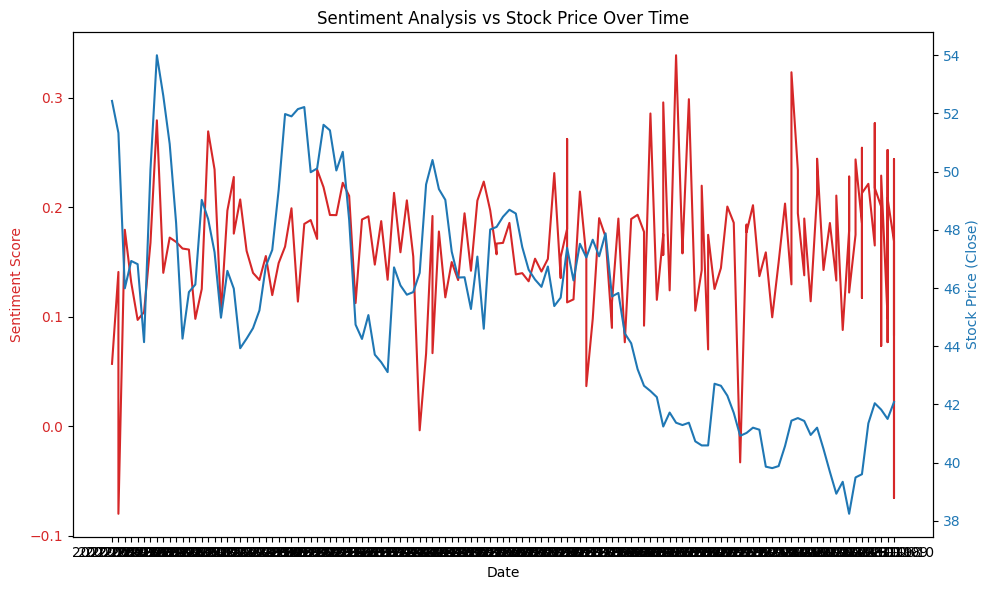

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3948  , p=0.5307  , df_denom=170, df_num=1
ssr based chi2 test:   chi2=0.4017  , p=0.5262  , df=1
likelihood ratio test: chi2=0.4013  , p=0.5264  , df=1
parameter F test:         F=0.3948  , p=0.5307  , df_denom=170, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4488  , p=0.0895  , df_denom=167, df_num=2
ssr based chi2 test:   chi2=5.0442  , p=0.0803  , df=2
likelihood ratio test: chi2=4.9716  , p=0.0833  , df=2
parameter F test:         F=2.4488  , p=0.0895  , df_denom=167, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8952  , p=0.1324  , df_denom=164, df_num=3
ssr based chi2 test:   chi2=5.9283  , p=0.1152  , df=3
likelihood ratio test: chi2=5.8278  , p=0.1203  , df=3
parameter F test:         F=1.8952  , p=0.1324  , df_denom=164, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7092  , p=0.1505  

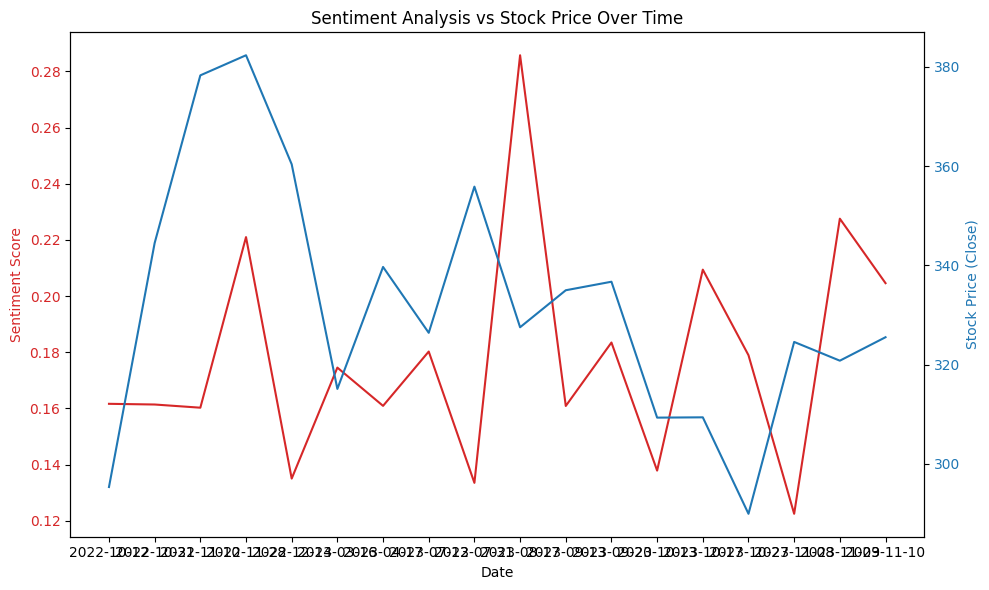

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0639  , p=0.8041  , df_denom=14, df_num=1
ssr based chi2 test:   chi2=0.0776  , p=0.7805  , df=1
likelihood ratio test: chi2=0.0774  , p=0.7808  , df=1
parameter F test:         F=0.0639  , p=0.8041  , df_denom=14, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2060  , p=0.8169  , df_denom=11, df_num=2
ssr based chi2 test:   chi2=0.5992  , p=0.7411  , df=2
likelihood ratio test: chi2=0.5883  , p=0.7452  , df=2
parameter F test:         F=0.2060  , p=0.8169  , df_denom=11, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3109  , p=0.8172  , df_denom=8, df_num=3
ssr based chi2 test:   chi2=1.7489  , p=0.6261  , df=3
likelihood ratio test: chi2=1.6542  , p=0.6472  , df=3
parameter F test:         F=0.3109  , p=0.8172  , df_denom=8, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4054  , p=0.7988  , df_den

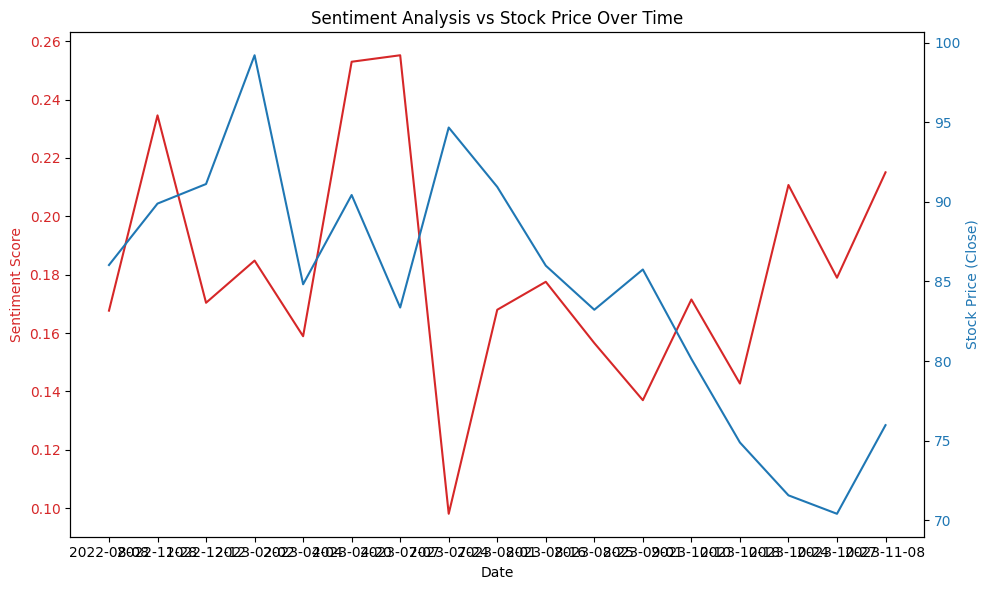

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4120  , p=0.5321  , df_denom=13, df_num=1
ssr based chi2 test:   chi2=0.5071  , p=0.4764  , df=1
likelihood ratio test: chi2=0.4992  , p=0.4799  , df=1
parameter F test:         F=0.4120  , p=0.5321  , df_denom=13, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.8511  , p=0.0043  , df_denom=10, df_num=2
ssr based chi2 test:   chi2=29.5532 , p=0.0000  , df=2
likelihood ratio test: chi2=16.3295 , p=0.0003  , df=2
parameter F test:         F=9.8511  , p=0.0043  , df_denom=10, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6142  , p=0.0188  , df_denom=7, df_num=3
ssr based chi2 test:   chi2=39.6851 , p=0.0000  , df=3
likelihood ratio test: chi2=18.8171 , p=0.0003  , df=3
parameter F test:         F=6.6142  , p=0.0188  , df_denom=7, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9166  , p=0.0567  , df_den

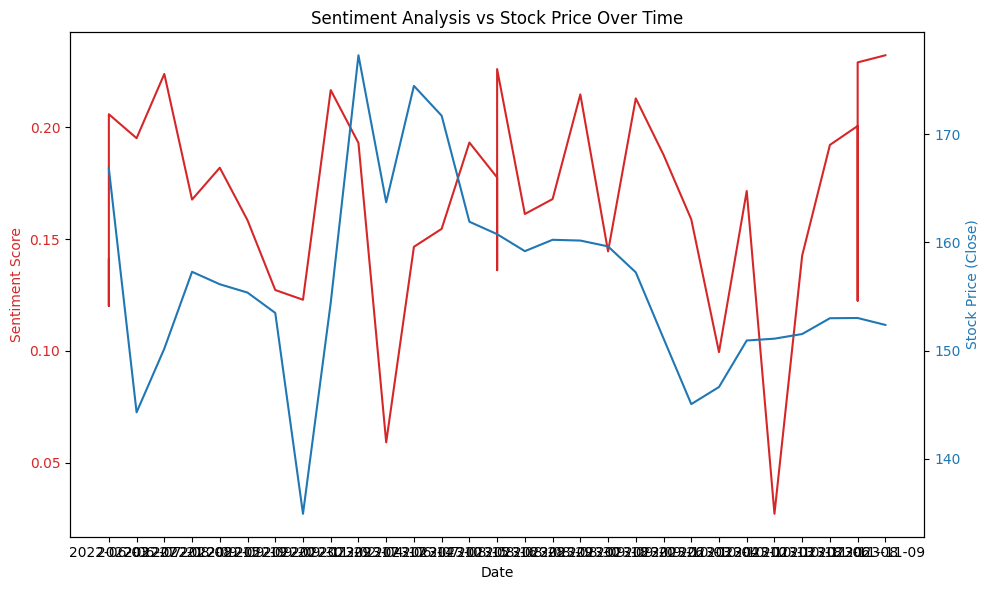

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3650  , p=0.5501  , df_denom=31, df_num=1
ssr based chi2 test:   chi2=0.4003  , p=0.5269  , df=1
likelihood ratio test: chi2=0.3980  , p=0.5281  , df=1
parameter F test:         F=0.3650  , p=0.5501  , df_denom=31, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2605  , p=0.7725  , df_denom=28, df_num=2
ssr based chi2 test:   chi2=0.6140  , p=0.7357  , df=2
likelihood ratio test: chi2=0.6084  , p=0.7377  , df=2
parameter F test:         F=0.2605  , p=0.7725  , df_denom=28, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2138  , p=0.8859  , df_denom=25, df_num=3
ssr based chi2 test:   chi2=0.8212  , p=0.8444  , df=3
likelihood ratio test: chi2=0.8108  , p=0.8469  , df=3
parameter F test:         F=0.2138  , p=0.8859  , df_denom=25, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0752  , p=0.9890  , df_d

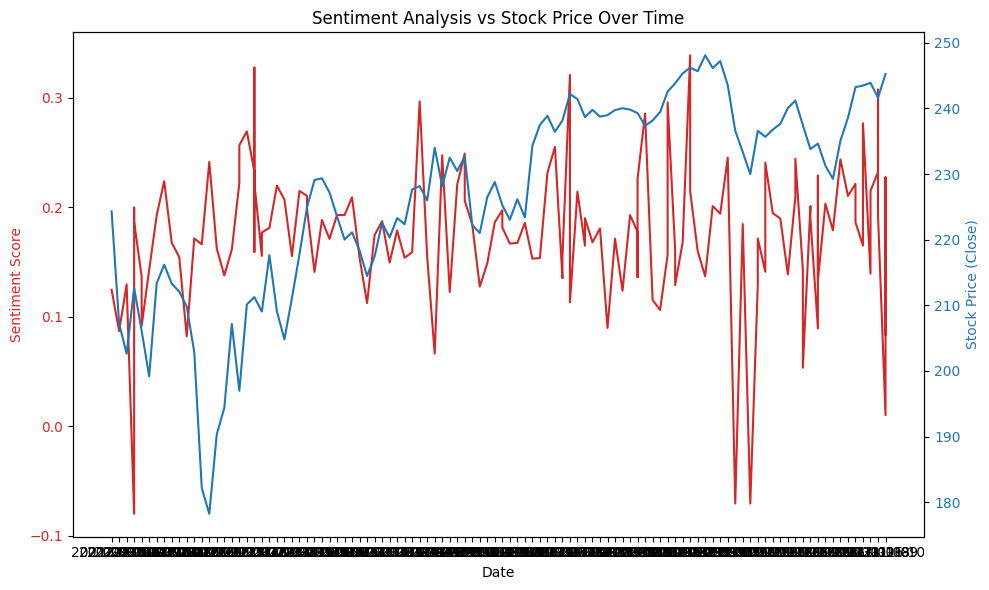

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3252  , p=0.5694  , df_denom=142, df_num=1
ssr based chi2 test:   chi2=0.3321  , p=0.5644  , df=1
likelihood ratio test: chi2=0.3317  , p=0.5647  , df=1
parameter F test:         F=0.3252  , p=0.5694  , df_denom=142, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2937  , p=0.7460  , df_denom=139, df_num=2
ssr based chi2 test:   chi2=0.6085  , p=0.7377  , df=2
likelihood ratio test: chi2=0.6073  , p=0.7381  , df=2
parameter F test:         F=0.2937  , p=0.7460  , df_denom=139, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2175  , p=0.8841  , df_denom=136, df_num=3
ssr based chi2 test:   chi2=0.6862  , p=0.8764  , df=3
likelihood ratio test: chi2=0.6845  , p=0.8768  , df=3
parameter F test:         F=0.2175  , p=0.8841  , df_denom=136, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5766  , p=0.6801  

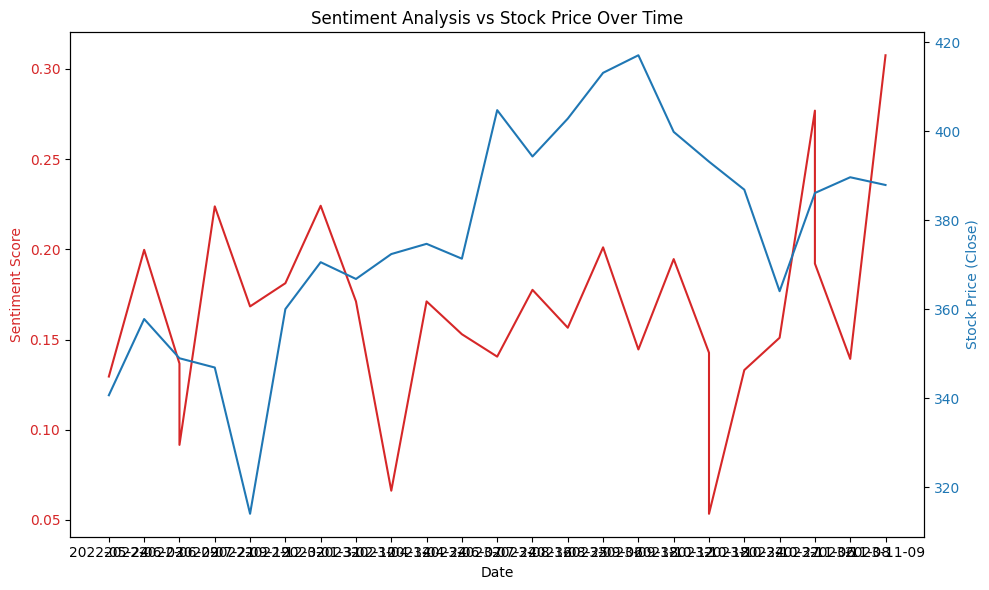

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0843  , p=0.7742  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=0.0959  , p=0.7569  , df=1
likelihood ratio test: chi2=0.0957  , p=0.7571  , df=1
parameter F test:         F=0.0843  , p=0.7742  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6143  , p=0.0993  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=6.6046  , p=0.0368  , df=2
likelihood ratio test: chi2=5.8343  , p=0.0541  , df=2
parameter F test:         F=2.6143  , p=0.0993  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8785  , p=0.0685  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=12.4134 , p=0.0061  , df=3
likelihood ratio test: chi2=9.9267  , p=0.0192  , df=3
parameter F test:         F=2.8785  , p=0.0685  , df_denom=16, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3969  , p=0.1036  , df_d

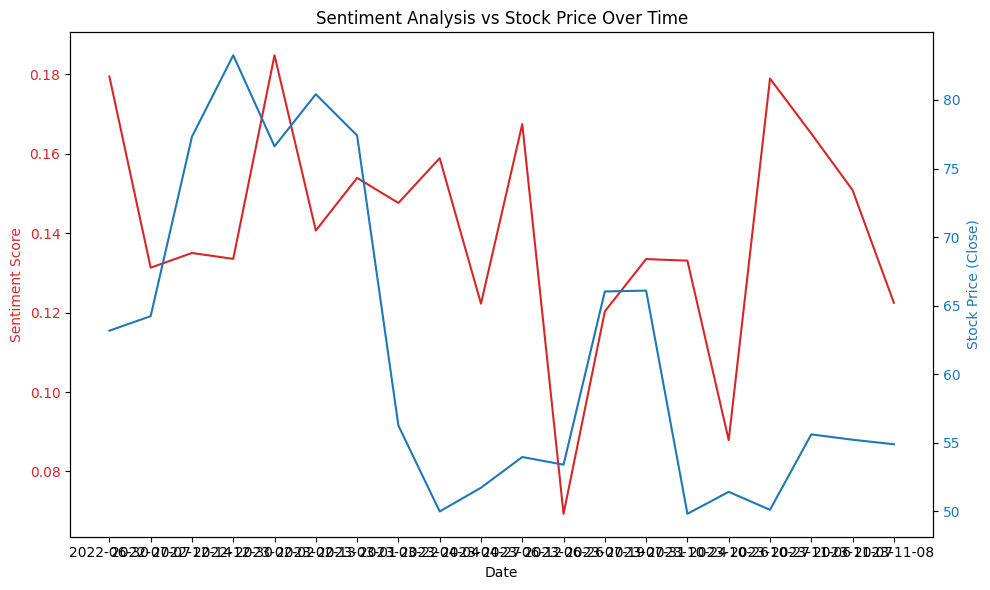


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3170  , p=0.5812  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=0.3764  , p=0.5395  , df=1
likelihood ratio test: chi2=0.3727  , p=0.5415  , df=1
parameter F test:         F=0.3170  , p=0.5812  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4183  , p=0.6667  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=1.1583  , p=0.5604  , df=2
likelihood ratio test: chi2=1.1226  , p=0.5705  , df=2
parameter F test:         F=0.4183  , p=0.6667  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0763  , p=0.9714  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=0.3892  , p=0.9425  , df=3
likelihood ratio test: chi2=0.3848  , p=0.9434  , df=3
parameter F test:         F=0.0763  , p=0.9714  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0956  , p=0.9806  , df_d

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [54]:
GrangerCausalityResultsTextBlob = {}
for key, value in stockDfs.items():
    mergedDf = pd.merge(value, filteredDfs[key], on='date')
    print("Company: ", key)
    # Print results per algorithm
    print("Text Blob Algorithm Results:- ")
    GrangerCausalityResultsTextBlob[key] = analysisPerAlgorithm(mergedDf, mergedDf['compoundT'], 'compoundT')

#### Granger Causality Results for Text Blob Algorithm

In [55]:
GrangerCausalityResultsTextBlob

{'JPM': [0.682, 0.844, 0.6033, 0.859, 0.7364],
 'BAC': [0.0214, 0.0226, 0.0341, 0.134, 0.0217],
 'WFC': [0.2688, 0.5359, 0.4339, 0.265, 0.1423],
 'C': [0.5262, 0.0803, 0.1152, 0.1248, 0.0306],
 'GS': [0.7805, 0.7411, 0.6261, 0.3378, 0.0],
 'MS': [0.4764, 0.0, 0.0, 0.0, 0.0],
 'AXP': [0.5269, 0.7357, 0.8444, 0.9805, 0.4927],
 'V': [0.5644, 0.7377, 0.8764, 0.6514, 0.6827],
 'MA': [0.7569, 0.0368, 0.0061, 0.0027, 0.0025],
 'SCHW': [0.5395, 0.5604, 0.9425, 0.9282, 0.5534]}

### VADER Algorithm results

Company:  JPM
VADER Algorithm Results:- 
Correlation value:  -0.0920981879724034


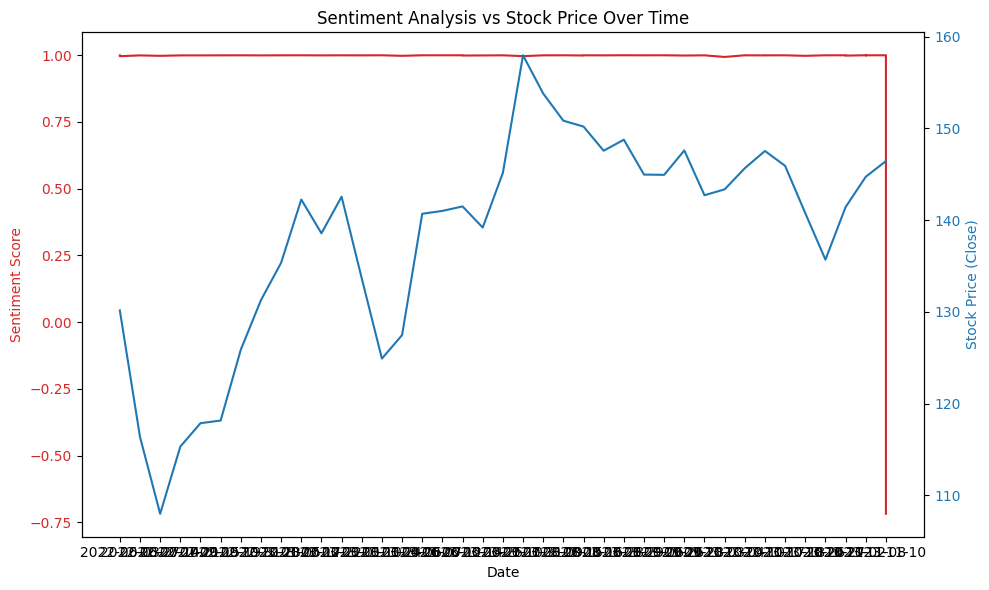

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4618  , p=0.5002  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=0.4919  , p=0.4831  , df=1
likelihood ratio test: chi2=0.4895  , p=0.4842  , df=1
parameter F test:         F=0.4618  , p=0.5002  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5757  , p=0.5666  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=1.2853  , p=0.5259  , df=2
likelihood ratio test: chi2=1.2684  , p=0.5304  , df=2
parameter F test:         F=0.5757  , p=0.5666  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2774  , p=0.8413  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=0.9780  , p=0.8066  , df=3
likelihood ratio test: chi2=0.9679  , p=0.8090  , df=3
parameter F test:         F=0.2774  , p=0.8413  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0772  , p=0.9888  , df_d

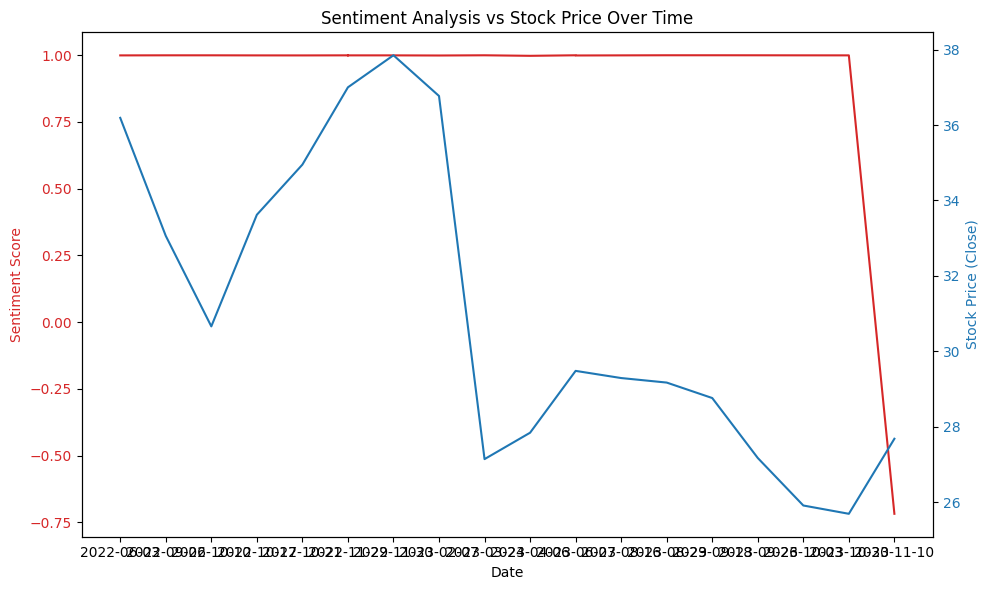

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9993  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9993  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9993  , df=1
parameter F test:         F=0.0000  , p=0.9993  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0280  , p=0.9725  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=0.0759  , p=0.9628  , df=2
likelihood ratio test: chi2=0.0757  , p=0.9628  , df=2
parameter F test:         F=0.0280  , p=0.9725  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3549  , p=0.7866  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=1.7423  , p=0.6276  , df=3
likelihood ratio test: chi2=1.6630  , p=0.6452  , df=3
parameter F test:         F=0.3549  , p=0.7866  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3245  , p=0.8541  , df_d

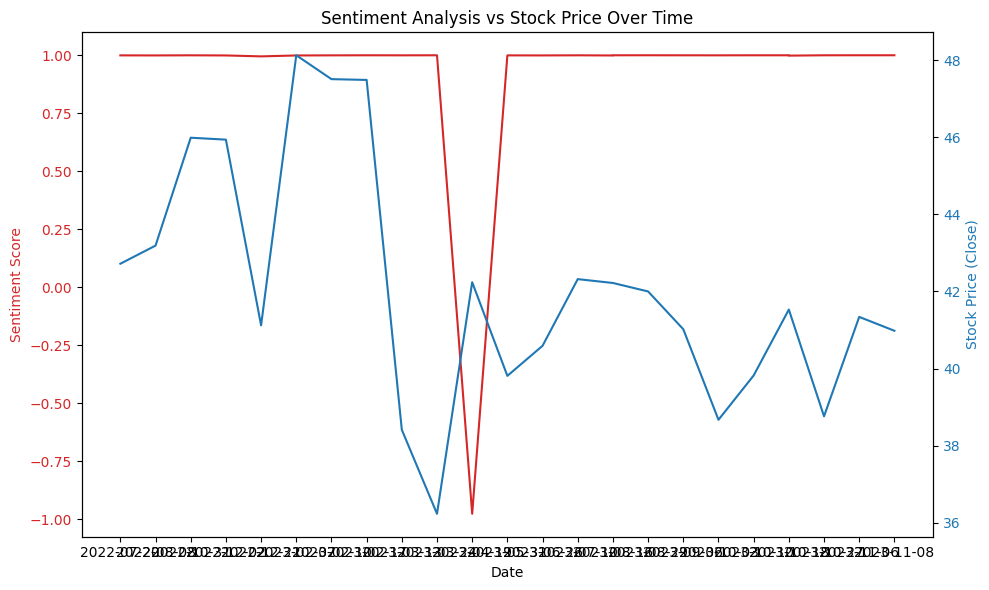

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6788  , p=0.4193  , df_denom=21, df_num=1
ssr based chi2 test:   chi2=0.7757  , p=0.3784  , df=1
likelihood ratio test: chi2=0.7635  , p=0.3822  , df=1
parameter F test:         F=0.6788  , p=0.4193  , df_denom=21, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5835  , p=0.5681  , df_denom=18, df_num=2
ssr based chi2 test:   chi2=1.4913  , p=0.4744  , df=2
likelihood ratio test: chi2=1.4449  , p=0.4856  , df=2
parameter F test:         F=0.5835  , p=0.5681  , df_denom=18, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3077  , p=0.8195  , df_denom=15, df_num=3
ssr based chi2 test:   chi2=1.3537  , p=0.7164  , df=3
likelihood ratio test: chi2=1.3137  , p=0.7259  , df=3
parameter F test:         F=0.3077  , p=0.8195  , df_denom=15, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6359  , p=0.6466  , df_d

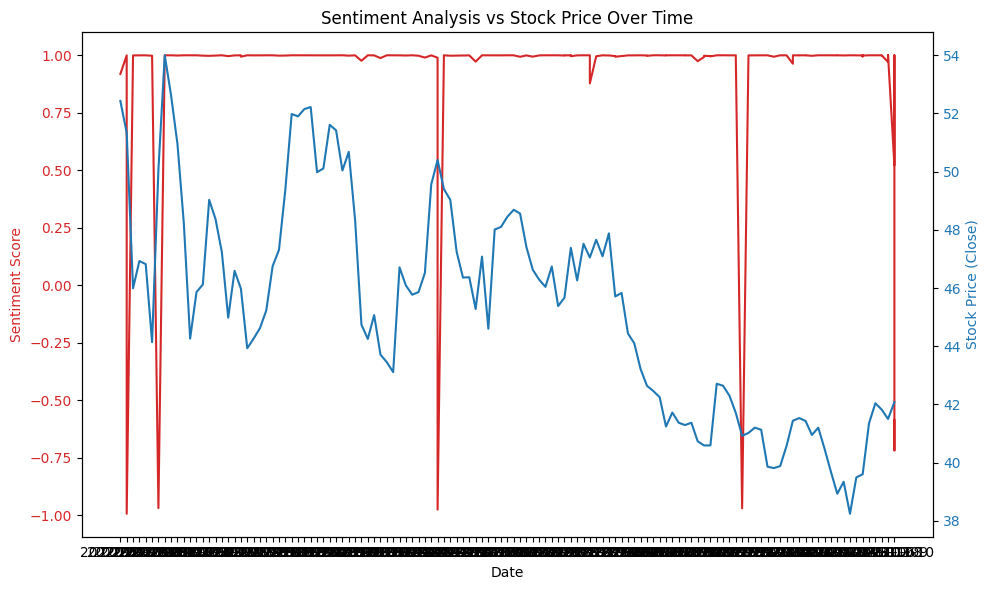

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2073  , p=0.6495  , df_denom=170, df_num=1
ssr based chi2 test:   chi2=0.2110  , p=0.6460  , df=1
likelihood ratio test: chi2=0.2108  , p=0.6461  , df=1
parameter F test:         F=0.2073  , p=0.6495  , df_denom=170, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1669  , p=0.8465  , df_denom=167, df_num=2
ssr based chi2 test:   chi2=0.3437  , p=0.8421  , df=2
likelihood ratio test: chi2=0.3434  , p=0.8422  , df=2
parameter F test:         F=0.1669  , p=0.8465  , df_denom=167, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3908  , p=0.7598  , df_denom=164, df_num=3
ssr based chi2 test:   chi2=1.2225  , p=0.7476  , df=3
likelihood ratio test: chi2=1.2182  , p=0.7486  , df=3
parameter F test:         F=0.3908  , p=0.7598  , df_denom=164, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6680  , p=0.1600  

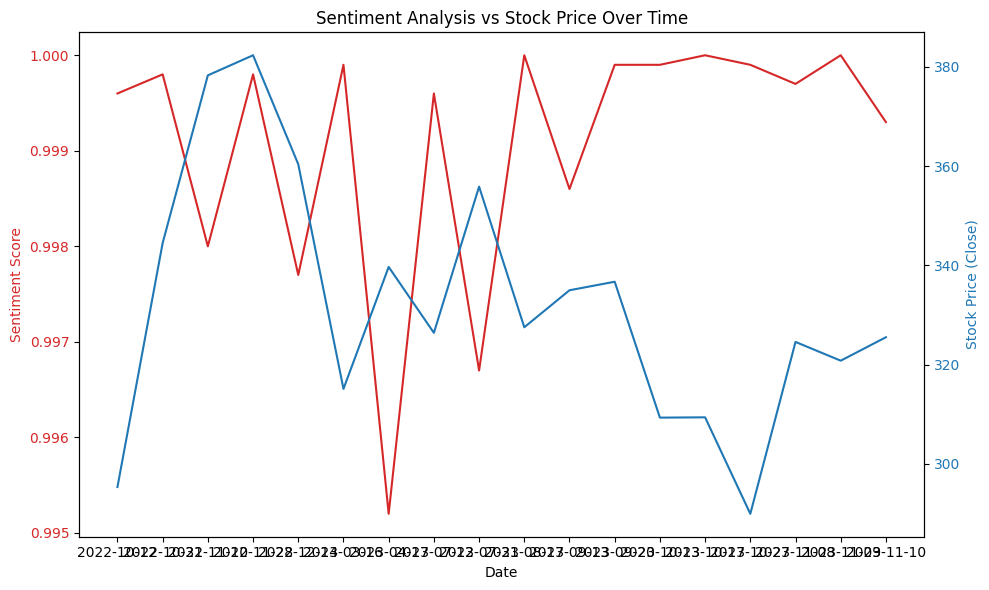

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7618  , p=0.3975  , df_denom=14, df_num=1
ssr based chi2 test:   chi2=0.9250  , p=0.3362  , df=1
likelihood ratio test: chi2=0.9007  , p=0.3426  , df=1
parameter F test:         F=0.7618  , p=0.3975  , df_denom=14, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0015  , p=0.1814  , df_denom=11, df_num=2
ssr based chi2 test:   chi2=5.8226  , p=0.0544  , df=2
likelihood ratio test: chi2=4.9657  , p=0.0835  , df=2
parameter F test:         F=2.0015  , p=0.1814  , df_denom=11, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6601  , p=0.5993  , df_denom=8, df_num=3
ssr based chi2 test:   chi2=3.7129  , p=0.2942  , df=3
likelihood ratio test: chi2=3.3175  , p=0.3452  , df=3
parameter F test:         F=0.6601  , p=0.5993  , df_denom=8, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8673  , p=0.2543  , df_den

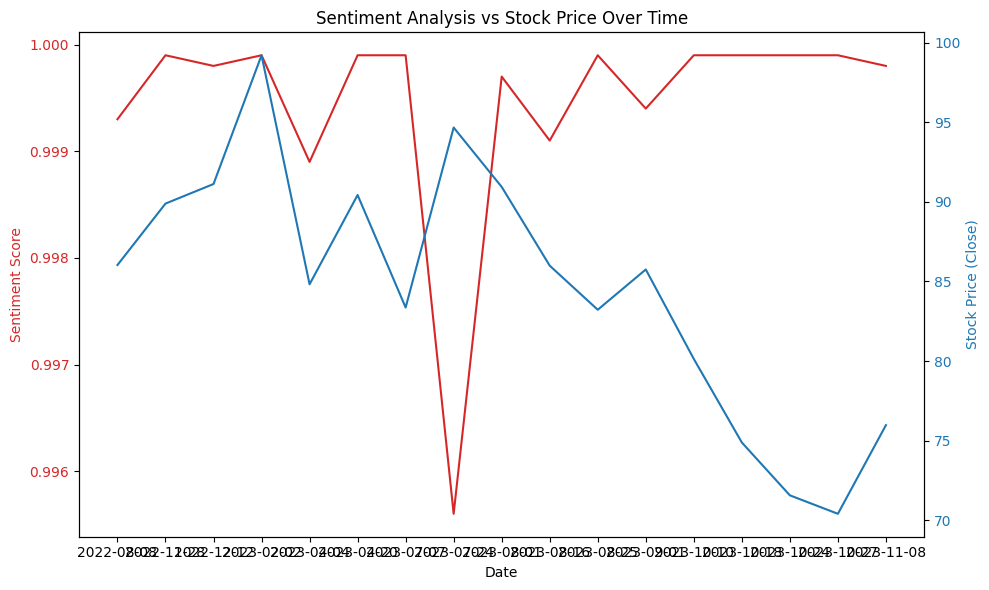

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0316  , p=0.8617  , df_denom=13, df_num=1
ssr based chi2 test:   chi2=0.0389  , p=0.8437  , df=1
likelihood ratio test: chi2=0.0388  , p=0.8438  , df=1
parameter F test:         F=0.0316  , p=0.8617  , df_denom=13, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4158  , p=0.6707  , df_denom=10, df_num=2
ssr based chi2 test:   chi2=1.2475  , p=0.5359  , df=2
likelihood ratio test: chi2=1.1983  , p=0.5493  , df=2
parameter F test:         F=0.4158  , p=0.6707  , df_denom=10, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3863  , p=0.7665  , df_denom=7, df_num=3
ssr based chi2 test:   chi2=2.3178  , p=0.5091  , df=3
likelihood ratio test: chi2=2.1448  , p=0.5429  , df=3
parameter F test:         F=0.3863  , p=0.7665  , df_denom=7, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9166  , p=0.5326  , df_den

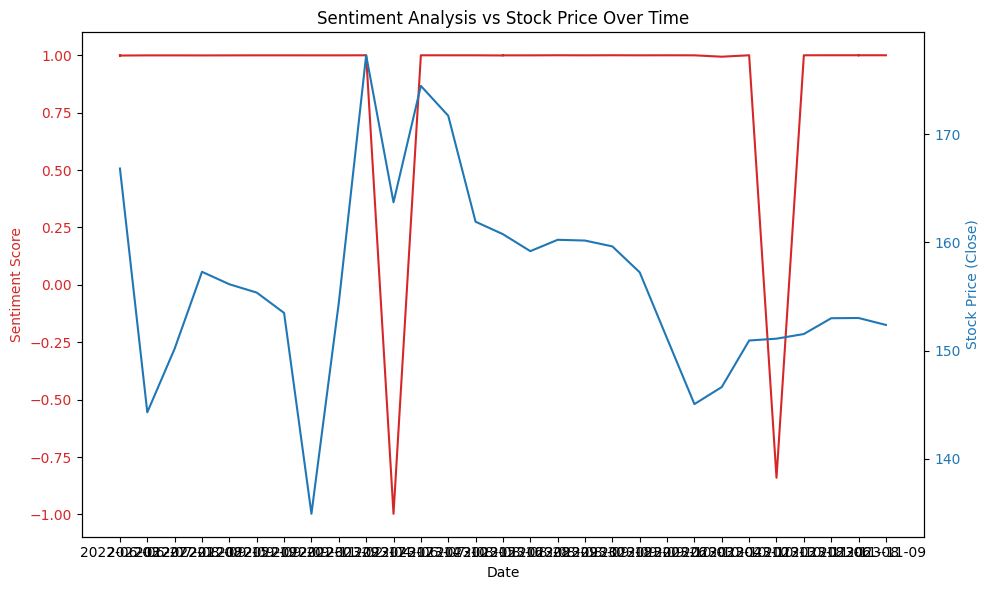

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6443  , p=0.2092  , df_denom=31, df_num=1
ssr based chi2 test:   chi2=1.8034  , p=0.1793  , df=1
likelihood ratio test: chi2=1.7572  , p=0.1850  , df=1
parameter F test:         F=1.6443  , p=0.2092  , df_denom=31, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2635  , p=0.2983  , df_denom=28, df_num=2
ssr based chi2 test:   chi2=2.9781  , p=0.2256  , df=2
likelihood ratio test: chi2=2.8513  , p=0.2403  , df=2
parameter F test:         F=1.2635  , p=0.2983  , df_denom=28, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3579  , p=0.2784  , df_denom=25, df_num=3
ssr based chi2 test:   chi2=5.2145  , p=0.1567  , df=3
likelihood ratio test: chi2=4.8308  , p=0.1846  , df=3
parameter F test:         F=1.3579  , p=0.2784  , df_denom=25, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5831  , p=0.6781  , df_d

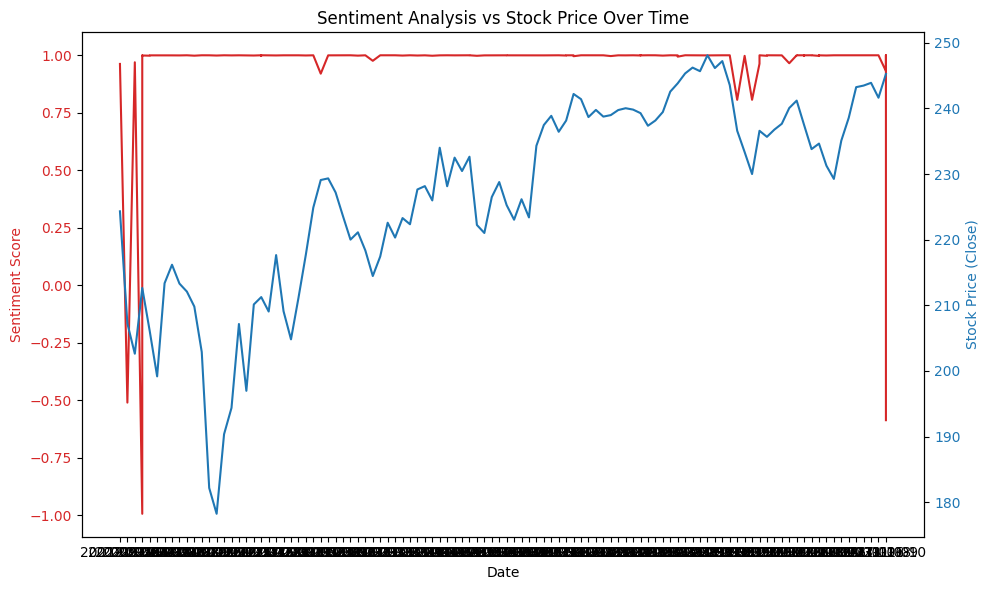

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6500  , p=0.4215  , df_denom=142, df_num=1
ssr based chi2 test:   chi2=0.6637  , p=0.4153  , df=1
likelihood ratio test: chi2=0.6622  , p=0.4158  , df=1
parameter F test:         F=0.6500  , p=0.4215  , df_denom=142, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7871  , p=0.4572  , df_denom=139, df_num=2
ssr based chi2 test:   chi2=1.6309  , p=0.4424  , df=2
likelihood ratio test: chi2=1.6217  , p=0.4445  , df=2
parameter F test:         F=0.7871  , p=0.4572  , df_denom=139, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3128  , p=0.8161  , df_denom=136, df_num=3
ssr based chi2 test:   chi2=0.9867  , p=0.8045  , df=3
likelihood ratio test: chi2=0.9833  , p=0.8053  , df=3
parameter F test:         F=0.3128  , p=0.8161  , df_denom=136, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8103  , p=0.5207  

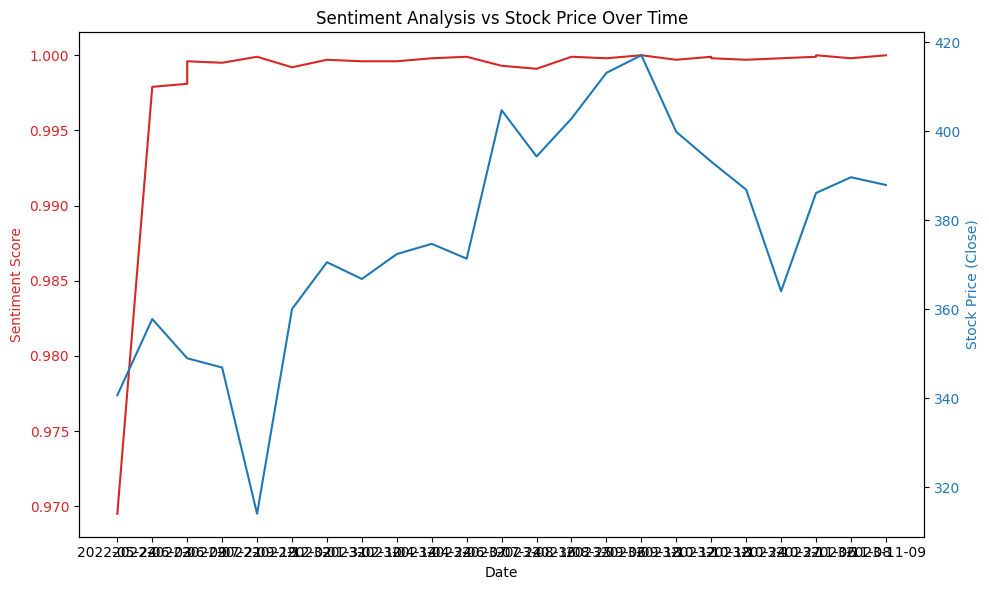

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0774  , p=0.7835  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=0.0879  , p=0.7668  , df=1
likelihood ratio test: chi2=0.0878  , p=0.7670  , df=1
parameter F test:         F=0.0774  , p=0.7835  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7423  , p=0.4893  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=1.8752  , p=0.3916  , df=2
likelihood ratio test: chi2=1.8055  , p=0.4054  , df=2
parameter F test:         F=0.7423  , p=0.4893  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2084  , p=0.8891  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=0.8987  , p=0.8257  , df=3
likelihood ratio test: chi2=0.8816  , p=0.8299  , df=3
parameter F test:         F=0.2084  , p=0.8891  , df_denom=16, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2245  , p=0.3477  , df_d

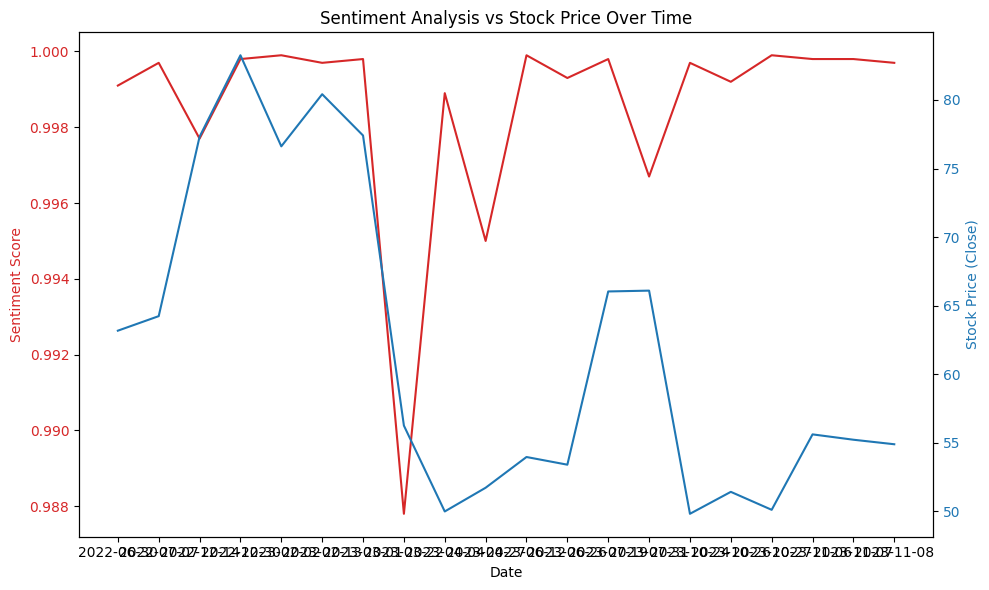


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2461  , p=0.2808  , df_denom=16, df_num=1
ssr based chi2 test:   chi2=1.4797  , p=0.2238  , df=1
likelihood ratio test: chi2=1.4249  , p=0.2326  , df=1
parameter F test:         F=1.2461  , p=0.2808  , df_denom=16, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1727  , p=0.8433  , df_denom=13, df_num=2
ssr based chi2 test:   chi2=0.4783  , p=0.7873  , df=2
likelihood ratio test: chi2=0.4721  , p=0.7898  , df=2
parameter F test:         F=0.1727  , p=0.8433  , df_denom=13, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2444  , p=0.8634  , df_denom=10, df_num=3
ssr based chi2 test:   chi2=1.2464  , p=0.7419  , df=3
likelihood ratio test: chi2=1.2028  , p=0.7523  , df=3
parameter F test:         F=0.2444  , p=0.8634  , df_denom=10, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6602  , p=0.6389  , df_d

/Users/namanlalit/anaconda3/envs/sentimentAnalysis/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [57]:
GrangerCausalityResultsVADER = {}
for key, value in stockDfs.items():
    mergedDf = pd.merge(value, filteredDfs[key], on='date')
    print("Company: ", key)
    # Print results per algorithm
    print("VADER Algorithm Results:- ")
    GrangerCausalityResultsVADER[key] = analysisPerAlgorithm(mergedDf, mergedDf['compoundV'], 'compoundV')

#### Granger Causality Results for VADER Algorithm

In [59]:
GrangerCausalityResultsVADER

{'JPM': [0.4831, 0.5259, 0.8066, 0.9838, 0.9728],
 'BAC': [0.9993, 0.9628, 0.6276, 0.5991, 0.4851],
 'WFC': [0.3784, 0.4744, 0.7164, 0.3483, 0.4495],
 'C': [0.646, 0.8421, 0.7476, 0.1335, 0.0802],
 'GS': [0.3362, 0.0544, 0.2942, 0.0003, 0.0],
 'MS': [0.8437, 0.5359, 0.5091, 0.018, 0.0],
 'AXP': [0.1793, 0.2256, 0.1567, 0.5111, 0.4863],
 'V': [0.4153, 0.4424, 0.8045, 0.4839, 0.7189],
 'MA': [0.7668, 0.3916, 0.8257, 0.0815, 0.0],
 'SCHW': [0.2238, 0.7873, 0.7419, 0.1965, 0.2216]}

## Based on the results above, TextBlob performs better results than VADER